In [13]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import klib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import Pool
from category_encoders import CatBoostEncoder
from sklearn.manifold import TSNE

plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [16]:
num = ['child_num', 'income_total', 'DAYS_BIRTH','DAYS_EMPLOYED', 'family_size', 'begin_month']
cat = ['gender', 'car', 'reality','income_type', 'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email','occyp_type']

In [17]:
# index(인덱스번호), FLAG_MOBIL(핸드폰 소유 여부) 컬럼 삭제

train = train.drop(columns = ['index', 'FLAG_MOBIL'])
test = test.drop(columns = ['index', 'FLAG_MOBIL'])

## <font color = mediumblue> ** 결측치 처리 **

In [18]:
# 고용되지 않은 사람 -> 'unemployed'로 처리

train.loc[train['DAYS_EMPLOYED'] > 0,'occyp_type'] = 'unemployed'
test.loc[test['DAYS_EMPLOYED'] > 0,'occyp_type'] = 'unemployed'

In [19]:
train = train.fillna('NaN')
test = test.fillna('NaN')

## <font color = mediumblue> ** 이상치 처리 **

#### 이상치 처리 전 ID 열 생성

In [25]:
info = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type','edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED','work_phone', 'phone', 'email', 'occyp_type', 'family_size']

train_customer = train.drop_duplicates(info)

train_customer.insert(0, 'ID', np.arange(0, len(train_customer)))
train_customer = train_customer.drop(columns=['begin_month', 'credit'])

train = pd.merge(train_customer, train , how='right', on=info)

test_customer = test.drop_duplicates(info)

test_customer.insert(0, 'ID', np.arange(0, len(test_customer)))
test_customer = test_customer.drop(columns=['begin_month'])

test = pd.merge(test_customer, test , how='right', on=info)

####  DAYS_BIRTH ,  begin_month

In [26]:
# 음수 -> 양수로 변환

train['DAYS_BIRTH'] = train['DAYS_BIRTH'] * -1
test['DAYS_BIRTH'] = test['DAYS_BIRTH'] * -1

train['begin_month'] = train['begin_month'] * -1
test['begin_month'] = test['begin_month'] * -1

#### DAYS_EMPLOYED 

In [27]:
# 고용되지 않은 사람 0으로 처리

train.loc[train['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = 0

In [28]:
# 음수 -> 양수로 변환

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'] * -1
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'] * -1

In [30]:
train.loc[train['child_num'] > 7, 'child_num']= 7
test.loc[test['child_num'] > 7, 'child_num']= 7

In [31]:
train.loc[train['family_size'] > 9, 'family_size']= 9
test.loc[test['family_size'] > 9, 'family_size']= 9

#### 표준화한 값의 절댓값이 3이상인 데이터 대체

In [29]:
train[num].describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,15958.053899,2198.529538,2.196848,26.123294
std,0.747326,1.018784e+05,4201.589022,2370.140530,0.916717,16.559550
min,0.000000,2.700000e+04,7705.000000,0.000000,1.000000,-0.000000
25%,0.000000,1.215000e+05,12446.000000,407.000000,2.000000,12.000000
50%,0.000000,1.575000e+05,15547.000000,1539.000000,2.000000,24.000000
75%,1.000000,2.250000e+05,19431.000000,3153.000000,3.000000,39.000000
max,19.000000,1.575000e+06,25152.000000,15713.000000,20.000000,60.000000


In [32]:
# 표준화한 값의 절댓값이 3 이상인 데이터를 clip을 활용해 대체하는 함수

def z_score_outlier(col):
    
    n_std =  np.std(train[col])
    n_mean = np.mean(train[col])
    
    upper = (3*n_std) + n_mean # 표준화 했을 때의 값이 3
    lower = ((-3)*n_std) + n_mean # 표준화 했을 때의 값이 -3
    
    train[col] = train[col].clip(lower=lower, upper=upper)
    test[col] = test[col].clip(lower=lower, upper=upper)

In [33]:
# 함수에 적용

z_score_outlier('income_total')

In [34]:
train[num].describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
count,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.427411,184830.586410,15958.053899,2198.529538,2.195752,26.123294
std,0.728768,89387.516632,4201.589022,2370.140530,0.903769,16.559550
min,0.000000,27000.000000,7705.000000,0.000000,1.000000,-0.000000
25%,0.000000,121500.000000,12446.000000,407.000000,2.000000,12.000000
50%,0.000000,157500.000000,15547.000000,1539.000000,2.000000,24.000000
75%,1.000000,225000.000000,19431.000000,3153.000000,3.000000,39.000000
max,7.000000,492935.852351,25152.000000,15713.000000,9.000000,60.000000


## <font color = mediumblue> ** Feature 생성 **

In [35]:
train.head()

,ID,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,NaN,2.0,6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0


<font color = 'navy'>**income/family** <font color = 'black'>-> 평균 소득

In [36]:
train['income/family'] = train['income_total'] / (train['family_size']+1)
test['income/family'] = test['income_total'] / (test['family_size']+1)

 <font color = 'navy'> **adult_num** <font color = 'black'> -> 어른 수

In [37]:
train['adult_num'] = train['family_size'] - train['child_num']
test['adult_num'] = test['family_size'] - test['child_num']

<font color = 'navy'>**age** <font color = 'black'>-> 나이

In [38]:
train['age'] = train['DAYS_BIRTH'] // 365
test['age'] = test['DAYS_BIRTH'] // 365

 <font color = 'navy'> **EMPLOYED** -> <font color = 'black'>업무 시작 여부

In [39]:
train['EMPLOYED'] = 0
test['EMPLOYED'] = 0

train.loc[train['DAYS_EMPLOYED'] > 0, 'EMPLOYED'] = 1
test.loc[test['DAYS_EMPLOYED'] > 0, 'EMPLOYED'] = 1

<font color = 'navy'> **MONTH_EMPLOYED**  <font color = 'black'> -> 고용된 지 몇 달 지났는지

In [40]:
train['MONTH_EMPLOYED'] = train['DAYS_EMPLOYED'] // 30
test['MONTH_EMPLOYED'] = test['DAYS_EMPLOYED'] // 30

 <font color = 'navy'> **YEAR_EMPLOYED**  <font color = 'black'> -> 고용된 지 몇 년 지났는 지

In [41]:
train['YEAR_EMPLOYED'] = train['DAYS_EMPLOYED'] // 365
test['YEAR_EMPLOYED'] = test['DAYS_EMPLOYED'] // 365

<font color = 'navy'> **YEAR_EMPLOYED_q** <font color = 'black'> -> YEAR_EMPLOYED_q 사분위

In [42]:
q1, q2, q3 = train['YEAR_EMPLOYED'].quantile([0.25, 0.5, 0.75])

train['YEAR_EMPLOYED_q'] = train['YEAR_EMPLOYED'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)
test['YEAR_EMPLOYED_q'] = test['YEAR_EMPLOYED'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)

 <font color = 'navy'> **DAYS_UNEMPLOYED** <font color = 'black'> -> 고용되기 시작한 일

In [43]:
train['DAYS_UNEMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
test['DAYS_UNEMPLOYED'] = test['DAYS_BIRTH'] - test['DAYS_EMPLOYED']

<font color = 'navy'> **GCR** <font color = 'black'> ->  gender, car, reality 합친 범주

In [44]:
train['GCR'] = train.gender + train.car + train.reality
test['GCR'] = test.gender + test.car+ test.reality

<font color = 'navy'> **WPE** <font color = 'black'> -> work_phone, phone, email 열 더한 feature

In [45]:
train['WPE'] = train.work_phone + train.phone + train.email
test['WPE'] = test.work_phone + test.phone + test.email

<font color = 'navy'> **reality_house** <font color = 'black'> -> reality, house type 문자열로 연결하여 부동산 소유여부, 생활방식 합친 feature

In [46]:
train['reality_house'] = train.reality +'_'+ train.house_type
test['reality_house'] = test.reality +'_'+ test.house_type

 <font color = 'navy'> **income_month** <font color = 'black'> -> 월 소득

In [47]:
train['income_month'] = train['income_total'] / 12
test['income_month'] = test['income_total'] / 12

<font color = 'navy'> **all_income** <font color = 'black'>  -> 총 소득

In [48]:
train['all_income'] = train['income_total'] * train['YEAR_EMPLOYED']
test['all_income'] = test['income_total'] * test['YEAR_EMPLOYED']

<font color = 'navy'> **begin_year** <font color = 'black'> -> 신용카드 발급한 지 몇 년 지났는지

In [49]:
train['begin_year'] = train['begin_month'] // 12
test['begin_year'] = test['begin_month'] // 12

<font color = 'navy'> **income_changed** -> <font color = 'black'> 소득 변화 여부

MONTH_EMPLOYED > begin_month -> 소득변화가 없었음<br>
MONTH_EMPLOYED < begin_month -> 소득변화가 있었음

In [50]:
train['income_changed'] = 0
test['income_changed'] = 0

train.loc[train['MONTH_EMPLOYED'] < train['begin_month'], 'income_changed'] = 1
test.loc[test['MONTH_EMPLOYED'] < test['begin_month'], 'income_changed'] = 1

# 추가 수치형 피쳐

In [51]:
train['나이_실수ver']= train['DAYS_BIRTH']/365
test['나이_실수ver']= test['DAYS_BIRTH']/365


In [52]:
def age_bumju(x):
    if 0<x<20:
        x= 0
    elif 20<= x<30:
        x=1
    elif 30<=x<40:
        x=2
    elif 40<=x<50:
        x=3
    elif 50<=x<60:
        x=4
    elif 60<=x<70:
        x=5
    else:
        x=6
    return x
train['나이_범주화']= train['나이_실수ver'].apply(age_bumju)
test['나이_범주화']= test['나이_실수ver'].apply(age_bumju)

In [53]:
q1,q2,q3= train['income_total'].quantile([0.25,0.5,0.75])

train['income_total_4']= train['income_total'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)
test['income_total_4']= test['income_total'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)

In [54]:
q1,q2,q3= train['DAYS_UNEMPLOYED'].quantile([0.25,0.5,0.75])

train['DAYS_UNEMPLOYED_4']= train['DAYS_UNEMPLOYED'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)
test['DAYS_UNEMPLOYED_4']= test['DAYS_UNEMPLOYED'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)

In [55]:
train['고용중x평균소득']= train['DAYS_EMPLOYED']* train['income/family']
test['고용중x평균소득']= test['DAYS_EMPLOYED']* test['income/family']

train['고용중x총소득']= train['DAYS_EMPLOYED']* train['income_total']
test['고용중x총소득']= test['DAYS_EMPLOYED']* test['income_total']

train['고용중xbirth']= train['DAYS_EMPLOYED']* train['DAYS_BIRTH']
test['고용중xbirth']= test['DAYS_EMPLOYED']* test['DAYS_BIRTH']

train['고용중xemploy']= train['DAYS_EMPLOYED']* train['DAYS_UNEMPLOYED']
test['고용중xemploy']= test['DAYS_EMPLOYED']* test['DAYS_UNEMPLOYED']

In [56]:
train['unemploy*birth']= train['DAYS_UNEMPLOYED']*train['DAYS_BIRTH']
test['unemploy*birth']= test['DAYS_UNEMPLOYED']*test['DAYS_BIRTH']

train['unemploy*income/family']= train['DAYS_UNEMPLOYED']*train['income/family']
test['unemploy*income/family']= test['DAYS_UNEMPLOYED']*test['income/family']

train['unemploy*employ']= train['DAYS_UNEMPLOYED']*train['DAYS_EMPLOYED']
test['unemploy*employ']= test['DAYS_UNEMPLOYED']*test['DAYS_EMPLOYED']

train['unemploy*income_total']=train['DAYS_UNEMPLOYED']*train['income_total']
test['unemploy*income_total']=test['DAYS_UNEMPLOYED']*test['income_total']

### begin month 중요도 높길래 범주형 피쳐 생성

In [58]:
def begin_bumju(x):
    if 0<=x<10:
        x= 0
    elif 10<= x<20:
        x=1
    elif 20<=x<30:
        x=2
    elif 30<=x<40:
        x=3
    elif 40<=x<50:
        x=4
    elif 50<=x<60:
        x=5
    elif 60<= x < 70:
        x=6
        
    else:
        x=7
    return x
train['발급월_범주화']= train['begin_month'].apply(age_bumju)
test['발급월_범주화']= test['begin_month'].apply(age_bumju)

<font color = 'navy'> **groupby 범주, 수치 열 생성**

- income type 기준

In [60]:
#total_income
income_mean_income = dict(train.groupby('income_type')['income_total'].mean())

train['income_mean_income'] = train['income_type'].apply(lambda x: income_mean_income[x])
test['income_mean_income'] = test['income_type'].apply(lambda x: income_mean_income[x])

income_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['income_sum_income'] = train['income_type'].apply(lambda x: income_sum_income[x])
test['income_sum_income'] = test['income_type'].apply(lambda x: income_sum_income[x])

income_std_income = dict(train.groupby('income_type')['income_total'].std())

train['income_std_income'] = train['income_type'].apply(lambda x: income_std_income[x])
test['income_std_income'] = test['income_type'].apply(lambda x: income_std_income[x])

In [61]:
#child_num
child_mean_income = train.groupby('income_type')['child_num'].mean()
train['child_mean_income'] = train['income_type'].apply(lambda x: child_mean_income[x])
test['child_mean_income'] = test['income_type'].apply(lambda x: child_mean_income[x])

child_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['child_sum_income'] = train['income_type'].apply(lambda x: child_sum_income[x])
test['child_sum_income'] = test['income_type'].apply(lambda x: child_sum_income[x])

child_std_income = dict(train.groupby('income_type')['income_total'].std())

train['child_std_income'] = train['income_type'].apply(lambda x: child_std_income[x])
test['child_std_income'] = test['income_type'].apply(lambda x: child_std_income[x])

In [62]:
#age
age_mean_income = train.groupby('income_type')['age'].mean()
train['age_mean_income'] = train['income_type'].apply(lambda x: age_mean_income[x])
test['age_mean_income'] = test['income_type'].apply(lambda x: age_mean_income[x])

age_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['age_sum_income'] = train['income_type'].apply(lambda x: age_sum_income[x])
test['age_sum_income'] = test['income_type'].apply(lambda x: age_sum_income[x])

age_std_income = dict(train.groupby('income_type')['income_total'].std())

train['age_std_income'] = train['income_type'].apply(lambda x: age_std_income[x])
test['age_std_income'] = test['income_type'].apply(lambda x: age_std_income[x])

In [63]:
#YEARS_EMPLOYED
EMPLOYED_mean_income = train.groupby('income_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_income'] = train['income_type'].apply(lambda x: EMPLOYED_mean_income[x])
test['EMPLOYED_mean_income'] = test['income_type'].apply(lambda x: EMPLOYED_mean_income[x])

EMPLOYED_sum_income = dict(train.groupby('income_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_income'] = train['income_type'].apply(lambda x: EMPLOYED_sum_income[x])
test['EMPLOYED_sum_income'] = test['income_type'].apply(lambda x: EMPLOYED_sum_income[x])

EMPLOYED_std_income = dict(train.groupby('income_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_income'] = train['income_type'].apply(lambda x: EMPLOYED_std_income[x])
test['EMPLOYED_std_income'] = test['income_type'].apply(lambda x: EMPLOYED_std_income[x])

- edu_type

In [64]:
#income_total
income_mean_edu = dict(train.groupby('edu_type')['income_total'].mean())

train['income_mean_edu'] = train['edu_type'].apply(lambda x: income_mean_edu[x])
test['income_mean_edu'] = test['edu_type'].apply(lambda x: income_mean_edu[x])

income_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['income_sum_edu'] = train['edu_type'].apply(lambda x: income_sum_edu[x])
test['income_sum_edu'] = test['edu_type'].apply(lambda x: income_sum_edu[x])

income_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['income_std_edu'] = train['edu_type'].apply(lambda x: income_std_edu[x])
test['income_std_edu'] = test['edu_type'].apply(lambda x: income_std_edu[x])

In [65]:
#child_num
child_mean_edu = train.groupby('edu_type')['child_num'].mean()
train['child_mean_edu'] = train['edu_type'].apply(lambda x: child_mean_edu[x])
test['child_mean_edu'] = test['edu_type'].apply(lambda x: child_mean_edu[x])

child_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['child_sum_edu'] = train['edu_type'].apply(lambda x: child_sum_edu[x])
test['child_sum_edu'] = test['edu_type'].apply(lambda x: child_sum_edu[x])

child_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['child_std_edu'] = train['edu_type'].apply(lambda x: child_std_edu[x])
test['child_std_edu'] = test['edu_type'].apply(lambda x: child_std_edu[x])

In [66]:
#age
age_mean_edu = train.groupby('edu_type')['age'].mean()
train['age_mean_edu'] = train['edu_type'].apply(lambda x: age_mean_edu[x])
test['age_mean_edu'] = test['edu_type'].apply(lambda x: age_mean_edu[x])

age_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['age_sum_edu'] = train['edu_type'].apply(lambda x: age_sum_edu[x])
test['age_sum_edu'] = test['edu_type'].apply(lambda x: age_sum_edu[x])

age_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['age_std_edu'] = train['edu_type'].apply(lambda x: age_std_edu[x])
test['age_std_edu'] = test['edu_type'].apply(lambda x: age_std_edu[x])

In [67]:
#YEARS_EMPLOYED
EMPLOYED_mean_edu = train.groupby('edu_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_mean_edu[x])
test['EMPLOYED_mean_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_mean_edu[x])

EMPLOYED_sum_edu = dict(train.groupby('edu_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_sum_edu[x])
test['EMPLOYED_sum_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_sum_edu[x])

EMPLOYED_std_edu = dict(train.groupby('edu_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_std_edu[x])
test['EMPLOYED_std_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_std_edu[x])

- house type

In [68]:
#income_total
income_mean_house = dict(train.groupby('house_type')['income_total'].mean())

train['income_mean_house'] = train['house_type'].apply(lambda x: income_mean_house[x])
test['income_mean_house'] = test['house_type'].apply(lambda x: income_mean_house[x])

income_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['income_sum_house'] = train['house_type'].apply(lambda x: income_sum_house[x])
test['income_sum_house'] = test['house_type'].apply(lambda x: income_sum_house[x])

income_std_house = dict(train.groupby('house_type')['income_total'].std())

train['income_std_house'] = train['house_type'].apply(lambda x: income_std_house[x])
test['income_std_house'] = test['house_type'].apply(lambda x: income_std_house[x])

In [69]:
#child_num
child_mean_house = train.groupby('house_type')['child_num'].mean()
train['child_mean_house'] = train['house_type'].apply(lambda x: child_mean_house[x])
test['child_mean_house'] = test['house_type'].apply(lambda x: child_mean_house[x])

child_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['child_sum_house'] = train['house_type'].apply(lambda x: child_sum_house[x])
test['child_sum_house'] = test['house_type'].apply(lambda x: child_sum_house[x])

child_std_house = dict(train.groupby('house_type')['income_total'].std())

train['child_std_house'] = train['house_type'].apply(lambda x: child_std_house[x])
test['child_std_house'] = test['house_type'].apply(lambda x: child_std_house[x])

In [70]:
#age
age_mean_house = train.groupby('house_type')['age'].mean()
train['age_mean_house'] = train['house_type'].apply(lambda x: age_mean_house[x])
test['age_mean_house'] = test['house_type'].apply(lambda x: age_mean_house[x])

age_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['age_sum_house'] = train['house_type'].apply(lambda x: age_sum_house[x])
test['age_sum_house'] = test['house_type'].apply(lambda x: age_sum_house[x])

age_std_house = dict(train.groupby('house_type')['income_total'].std())

train['age_std_house'] = train['house_type'].apply(lambda x: age_std_house[x])
test['age_std_house'] = test['house_type'].apply(lambda x: age_std_house[x])

In [71]:
#YEARS_EMPLOYED
EMPLOYED_mean_house = train.groupby('house_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_house'] = train['house_type'].apply(lambda x: EMPLOYED_mean_house[x])
test['EMPLOYED_mean_house'] = test['house_type'].apply(lambda x: EMPLOYED_mean_house[x])

EMPLOYED_sum_house = dict(train.groupby('house_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_house'] = train['house_type'].apply(lambda x: EMPLOYED_sum_house[x])
test['EMPLOYED_sum_house'] = test['house_type'].apply(lambda x: EMPLOYED_sum_house[x])

EMPLOYED_std_house = dict(train.groupby('house_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_house'] = train['house_type'].apply(lambda x: EMPLOYED_std_house[x])
test['EMPLOYED_std_house'] = test['house_type'].apply(lambda x: EMPLOYED_std_house[x])

- family type

In [72]:
#income_total
income_mean_family = dict(train.groupby('family_type')['income_total'].mean())

train['income_mean_family'] = train['family_type'].apply(lambda x: income_mean_family[x])
test['income_mean_family'] = test['family_type'].apply(lambda x: income_mean_family[x])

income_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['income_sum_family'] = train['family_type'].apply(lambda x: income_sum_family[x])
test['income_sum_family'] = test['family_type'].apply(lambda x: income_sum_family[x])

income_std_family = dict(train.groupby('family_type')['income_total'].std())

train['income_std_family'] = train['family_type'].apply(lambda x: income_std_family[x])
test['income_std_family'] = test['family_type'].apply(lambda x: income_std_family[x])

In [73]:
#child_num
child_mean_family = train.groupby('family_type')['child_num'].mean()
train['child_mean_family'] = train['family_type'].apply(lambda x: child_mean_family[x])
test['child_mean_family'] = test['family_type'].apply(lambda x: child_mean_family[x])

child_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['child_sum_family'] = train['family_type'].apply(lambda x: child_sum_family[x])
test['child_sum_family'] = test['family_type'].apply(lambda x: child_sum_family[x])

child_std_family = dict(train.groupby('family_type')['income_total'].std())

train['child_std_family'] = train['family_type'].apply(lambda x: child_std_family[x])
test['child_std_family'] = test['family_type'].apply(lambda x: child_std_family[x])

In [74]:
#age
age_mean_family = train.groupby('family_type')['age'].mean()
train['age_mean_family'] = train['family_type'].apply(lambda x: age_mean_family[x])
test['age_mean_family'] = test['family_type'].apply(lambda x: age_mean_family[x])

age_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['age_sum_family'] = train['family_type'].apply(lambda x: age_sum_family[x])
test['age_sum_family'] = test['family_type'].apply(lambda x: age_sum_family[x])

age_std_family = dict(train.groupby('family_type')['income_total'].std())

train['age_std_family'] = train['family_type'].apply(lambda x: age_std_family[x])
test['age_std_family'] = test['family_type'].apply(lambda x: age_std_family[x])

In [75]:
#YEARS_EMPLOYED
EMPLOYED_mean_family = train.groupby('family_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_family'] = train['family_type'].apply(lambda x: EMPLOYED_mean_family[x])
test['EMPLOYED_mean_family'] = test['family_type'].apply(lambda x: EMPLOYED_mean_family[x])

EMPLOYED_sum_family = dict(train.groupby('family_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_family'] = train['family_type'].apply(lambda x: EMPLOYED_sum_family[x])
test['EMPLOYED_sum_family'] = test['family_type'].apply(lambda x: EMPLOYED_sum_family[x])

EMPLOYED_std_family = dict(train.groupby('family_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_family'] = train['family_type'].apply(lambda x: EMPLOYED_std_family[x])
test['EMPLOYED_std_family'] = test['family_type'].apply(lambda x: EMPLOYED_std_family[x])

## <font color = mediumblue> ** Scaling **

In [77]:
num = ['child_num', 'income_total', 'DAYS_BIRTH','DAYS_EMPLOYED', 'family_size',  'begin_month', 'income/family', 'adult_num', 'age', 'MONTH_EMPLOYED', 'YEAR_EMPLOYED',
       'DAYS_UNEMPLOYED', 'WPE', 'income_month', 'all_income','begin_year' ,'income_mean_income', 'income_sum_income', 'income_std_income',
       'child_mean_income', 'child_sum_income', 'child_std_income',
       'age_mean_income', 'age_sum_income', 'age_std_income',
       'EMPLOYED_mean_income', 'EMPLOYED_sum_income', 'EMPLOYED_std_income',
       'income_mean_edu', 'income_sum_edu', 'income_std_edu', 'child_mean_edu',
       'child_sum_edu', 'child_std_edu', 'age_mean_edu', 'age_sum_edu',
       'age_std_edu', 'EMPLOYED_mean_edu', 'EMPLOYED_sum_edu',
       'EMPLOYED_std_edu', 'income_mean_house', 'income_sum_house',
       'income_std_house', 'child_mean_house', 'child_sum_house',
       'child_std_house', 'age_mean_house', 'age_sum_house', 'age_std_house',
       'EMPLOYED_mean_house', 'EMPLOYED_sum_house', 'EMPLOYED_std_house',
       'income_mean_family', 'income_sum_family', 'income_std_family',
       'child_mean_family', 'child_sum_family', 'child_std_family',
       'age_mean_family', 'age_sum_family', 'age_std_family',
       'EMPLOYED_mean_family', 'EMPLOYED_sum_family', 'EMPLOYED_std_family']
cat = ['ID', 'gender', 'car', 'reality','income_type', 'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email','occyp_type', 'EMPLOYED', 'YEAR_EMPLOYED_q', 'GCR', 'reality_house', 'income_changed'
      ,'나이_실수ver', 'income_total_4', 'DAYS_UNEMPLOYED_4', '고용중x평균소득',
       '고용중x총소득', '고용중xbirth', '고용중xemploy', 'unemploy*birth',
       'unemploy*income/family', 'unemploy*employ', 'unemploy*income_total','나이_범주화','발급월_범주화']

#### - MinMaxScaler -

In [78]:
scaler = MinMaxScaler()
train[num] = scaler.fit_transform(train[num])
test[num] = scaler.transform(test[num])

#### - 로그변환 -

In [79]:
train[num] = np.log1p(train[num])
test[num] = np.log1p(test[num])

## <font color = mediumblue> ** Encoding **

#### - binary encoding -

In [80]:
train['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0)
test['gender'] = test['gender'].apply(lambda x: 1 if x=='M' else 0)

train['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0)
test['car'] = test['car'].apply(lambda x: 1 if x=='Y' else 0)

train['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0)
test['reality'] = test['reality'].apply(lambda x: 1 if x=='Y' else 0)

#### - Ordinary encoding -

In [81]:
train.loc[train['edu_type'] == 'Lower secondary', 'edu_type'] = 0
train.loc[train['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 1
train.loc[train['edu_type'] == 'Incomplete higher', 'edu_type'] = 2
train.loc[train['edu_type'] == 'Higher education', 'edu_type'] = 3
train.loc[train['edu_type'] == 'Academic degree', 'edu_type'] = 4

test.loc[test['edu_type'] == 'Lower secondary', 'edu_type'] = 0
test.loc[test['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 1
test.loc[test['edu_type'] == 'Incomplete higher', 'edu_type'] = 2
test.loc[test['edu_type'] == 'Higher education', 'edu_type'] = 3
test.loc[test['edu_type'] == 'Academic degree', 'edu_type'] = 4

#### - Label encoding -

In [82]:
# Label Encoding 할 feature들

label_col = ['ID', 'income_type', 'family_type', 'house_type', 'occyp_type', 'GCR', 'reality_house']

In [83]:
for col in label_col:
    lbencoder = LabelEncoder()
    lbencoder.fit(train[col])
    train[col] = lbencoder.transform(train[col])
    test[col] = lbencoder.transform(test[col])

#### -Target encoding -

- 성능 너무 떨어짐요

import category_encoders as ce
te = ce.TargetEncoder(cols=label_col, min_samples_leaf=5, smoothing=50) 

te.fit(train[label_col],train_y)
train[label_col] = te.transform(train[label_col])
test[label_col] = te.transform(train[label_col])

## <font color = mediumblue> ** Feature Selection **

In [84]:
train1, test1 = train.copy(), test.copy()

In [85]:
train_X = train1.drop(columns='credit')
test_X = test1
train_y = train['credit']

#### - target과의 상관관계 -

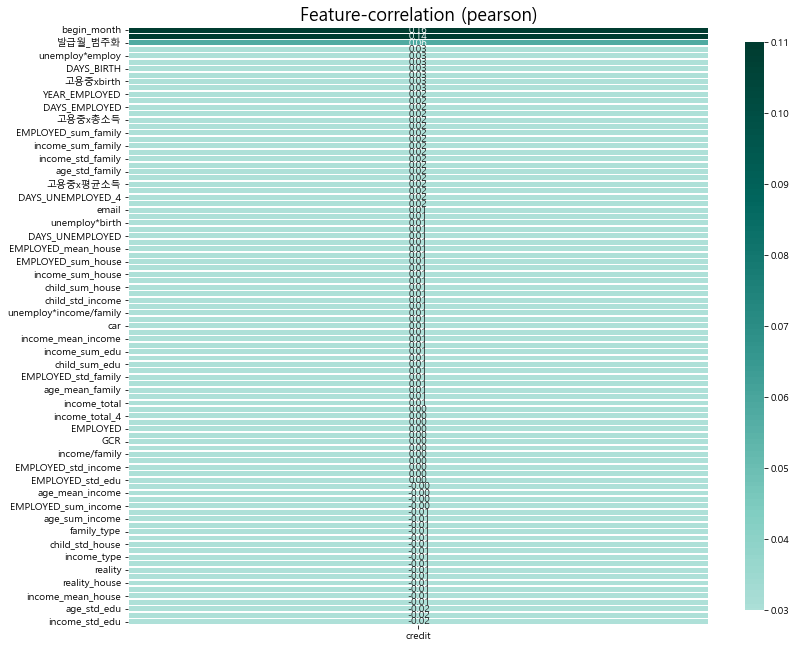

In [86]:
klib.corr_plot(data =train_X, 
               target =train_y,
               figsize = (13, 11))

plt.show()

- CatBoost

In [87]:
selector = SelectFromModel(RandomForestClassifier(random_state=0), threshold=None)
train_fs = selector.fit(train_X, train_y).transform(train_X)
test_fs = selector.transform(test_X)

mask = selector.get_support()

fs_dict = {}
for i in range(len(train_X.columns)):
    fs_dict[train_X.columns[i]] = mask[i]

In [88]:
print("X_train.shape: {},  train_fs.shape: {}".format(train_X.shape, train_fs.shape))

X_train.shape: (26457, 94),  train_fs.shape: (26457, 24)


### SELECTION 된 FEATURE들

In [89]:
col_lst = []
for i in list(train_X.columns):
    if fs_dict[i] ==True:
        col_lst.append(i)
    
col_lst

['ID',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'occyp_type',
 'begin_month',
 'income/family',
 'age',
 'MONTH_EMPLOYED',
 'DAYS_UNEMPLOYED',
 'GCR',
 'income_month',
 'all_income',
 'begin_year',
 '나이_실수ver',
 '고용중x평균소득',
 '고용중x총소득',
 '고용중xbirth',
 '고용중xemploy',
 'unemploy*birth',
 'unemploy*income/family',
 'unemploy*employ',
 'unemploy*income_total',
 '발급월_범주화']

In [90]:
train_X1 = pd.DataFrame(train_fs, columns=col_lst)
test_X1 = pd.DataFrame(test_fs, columns=col_lst)

## MY OWN FEATURE SELECTION 

In [91]:
cb = RandomForestClassifier(random_state=0)
cb.fit(train_X, train_y)
feature_import = pd.Series(cb.feature_importances_, train_X.columns)

#### 중요도 0.004 이하 피쳐들

In [93]:
len(feature_import[feature_import.sort_values(ascending=False)<0.004])

59

In [94]:
cut_im = feature_import[feature_import.sort_values(ascending=False)<0.004].keys()

In [95]:
train_X.corrwith(train_y)[(-0.005<train_X.corrwith(train_y).sort_values(ascending=True))&(train_X.corrwith(train_y).sort_values(ascending=True)<0.005)].keys()

Index(['gender', 'child_num', 'work_phone', 'phone', 'income/family',
       'EMPLOYED', 'GCR', 'WPE', 'income_total_4', 'child_mean_income',
       'age_mean_income', 'EMPLOYED_mean_income', 'EMPLOYED_sum_income',
       'EMPLOYED_std_income', 'EMPLOYED_std_edu', 'child_mean_house'],
      dtype='object')

In [96]:
cut_corr =train_X.corrwith(train_y)[(-0.005<train_X.corrwith(train_y).sort_values(ascending=True))&(train_X.corrwith(train_y).sort_values(ascending=True)<0.005)].keys() 

In [97]:
all_col = list(train_X.columns)
len(all_col)

94

#### target과의 corr 절댓값이 0.005보다 작은 열들과 importance 0.004보다 작은 열들의 교집합 제거한 피쳐들

In [98]:
col_im_corr = [x for x in cut_im if x in cut_corr]
len(col_im_corr)

9

In [99]:
col_cutted_im_corr = [x for x in all_col if x not in col_im_corr]
len(col_cutted_im_corr)

85

In [100]:
train_X_corr_im = train_X[col_cutted_im_corr]
test_X_corr_im = test_X[col_cutted_im_corr]

#### importance를 기준으로만 셀렉션 한 열들

In [101]:
col_cutted_im = [x for x in all_col if x not in cut_im]
len(col_cutted_im)

35

In [103]:
train_X_im = train_X[col_cutted_im]
test_X_im = test_X[col_cutted_im]

## <font color = mediumblue> ** Modeling **

# model tuning using optuna

In [85]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler

In [245]:
def objective(trial: Trial) -> float:
    params_lgb = {
       'random_state':0,
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        'min_samples_leaf' : trial.suggest_int( 'min_samples_leaf',5,15 ),
        'min_samples_split': trial.suggest_int('min_samples_split',5,20 ),
        "max_features": trial.suggest_int("max_features", 1, 5),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2)

    model = RandomForestClassifier(**params_lgb)
    model.fit(X_train, y_train)

    pred = model.predict_proba(X_valid)
    score = log_loss(y_valid, pred)
    
    return score

In [246]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-11-27 16:11:43,589] A new study created in memory with name: rf_parameter_opt
[I 2022-11-27 16:11:50,291] Trial 0 finished with value: 0.8111575141288773 and parameters: {'max_depth': 10, 'n_estimators': 481, 'min_samples_leaf': 13, 'min_samples_split': 14, 'max_features': 1}. Best is trial 0 with value: 0.8111575141288773.
[I 2022-11-27 16:11:54,002] Trial 1 finished with value: 0.8047900752216183 and parameters: {'max_depth': 7, 'n_estimators': 123, 'min_samples_leaf': 14, 'min_samples_split': 14, 'max_features': 4}. Best is trial 1 with value: 0.8047900752216183.
[I 2022-11-27 16:11:58,289] Trial 2 finished with value: 0.856227488352956 and parameters: {'max_depth': 5, 'n_estimators': 488, 'min_samples_leaf': 14, 'min_samples_split': 8, 'max_features': 1}. Best is trial 1 with value: 0.8047900752216183.
[I 2022-11-27 16:12:02,052] Trial 3 finished with value: 0.8125218614313203 and parameters: {'max_depth': 7, 'n_estimators': 222, 'min_samples_leaf': 10, 'min_samples_split':

Best Score: 0.7312054302216102
Best trial: {'max_depth': 20, 'n_estimators': 374, 'min_samples_leaf': 7, 'min_samples_split': 5, 'max_features': 4}


In [197]:
train1, test1 = train.copy(), test.copy()

In [198]:
train_X = train1.drop(columns='credit')
test_X = test1
train_y = train['credit']
train_X.shape, test_X.shape

((26457, 94), (10000, 94))

In [239]:
train_X, test_X = train_X1.copy(), test_X1.copy()
train_X.shape, test_X.shape

((26457, 24), (10000, 24))

In [112]:
model = RandomForestClassifier(**study.best_trial.params)
cv = StratifiedKFold(n_splits=15) 

cr_list = []
sub=np.zeros((test.shape[0], 3)) 

for train_index, test_index in cv.split(train_X, train_y) :
    x_train, x_test = train_X.iloc[list(train_index)], train_X.iloc[list(test_index)]
    y_train, y_test = train_y.iloc[list(train_index)], train_y.iloc[list(test_index)]
        #x_train = PolynomialFeatures().fit_transform(x_train)
        #x_test = PolynomialFeatures().fit_transform(x_test)
    model = rf_model.fit(x_train,y_train)#, early_stopping_rounds=100, verbose=False)
    pred = model.predict_proba(x_test)
    cross_entropy = log_loss(y_test, pred)
    cr_list.append(cross_entropy)
    sub +=model.predict_proba(test_X)  

mysubmission = sub/15

score = sum(cr_list)/15

In [113]:
print('logloss:', score)

logloss: 0.7367359383863349


In [256]:
filename = f'randomforest_{score:.3f}.csv'

In [257]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.loc[:,1:]=mysubmission

In [258]:
submission.to_csv(filename, index=False)